In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install --upgrade ultralytics
# !pip install --upgrade -U ray[tune]

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

! wandb disabled

/bin/bash: line 1: wandb: command not found


In [4]:
class CFG:
    DEBUG = True  # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = [
        'Helmet', 'Safety Glasses', 'Face Mask', 'Protective Clothing', 'Safety Vest',
        'Gloves', 'Hearing Protection', 'Boots', 'Respirator', 'Goggles',
        'Apron', 'Knee Pads', 'Elbow Pads', 'High-Visibility Clothing',
        'Fall Protection Harness', 'Welding Mask', 'Dust Mask'
    ]

    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 5  # 100
    BATCH_SIZE = -1

    BASE_MODEL = 'yolov9e'  # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = "AdamW"  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-5
    DROPOUT = 0.2
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.1

    # paths
    CUSTOM_DATASET_DIR = "/home/nickolasz/Projects/DataSets/GoIT/PPE_DATASET_YOLOv8/"
    OUTPUT_DIR = (
        "/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/"
    )

In [5]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [6]:
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Helmet
- Safety Glasses
- Face Mask
- Protective Clothing
- Safety Vest
- Gloves
- Hearing Protection
- Boots
- Respirator
- Goggles
- Apron
- Knee Pads
- Elbow Pads
- High-Visibility Clothing
- Fall Protection Harness
- Welding Mask
- Dust Mask
nc: 17
test: /home/nickolasz/Projects/DataSets/GoIT/PPE_DATASET_YOLOv8/test
train: /home/nickolasz/Projects/DataSets/GoIT/PPE_DATASET_YOLOv8/train
val: /home/nickolasz/Projects/DataSets/GoIT/PPE_DATASET_YOLOv8/valid



In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_image(image_path, print_info=True, hide_axis=False):
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        return

    # Open the image
    img = Image.open(image_path)

    # Print image info if needed
    if print_info:
        print(f"Image Path: {image_path}")
        print(f"Image Size: {img.size}")
        print(f"Image Mode: {img.mode}")

    # Display the image
    plt.imshow(img)
    if hide_axis:
        plt.axis('off')
    plt.show()

Image Path: /home/nickolasz/Projects/DataSets/GoIT/PPE_DATASET_YOLOv8/train/images/-1022-_png_jpg.rf.f81307d5d7695fd0061ebb88c6a11ebd.jpg
Image Size: (640, 640)
Image Mode: RGB


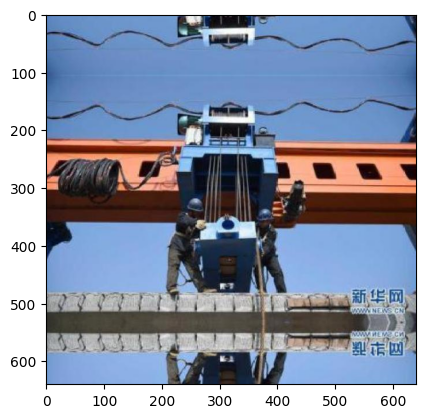

In [8]:
# Example usage
example_image_path = "/home/nickolasz/Projects/DataSets/GoIT/PPE_DATASET_YOLOv8/train/images/-1022-_png_jpg.rf.f81307d5d7695fd0061ebb88c6a11ebd.jpg"
display_image(example_image_path, print_info=True, hide_axis=False)

In [9]:
# Function to get image properties after resizing
def get_image_properties(image_path, new_size=(640, 640)):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Resize the image to the new size
    img_resized = cv2.resize(img, new_size)

    # Get resized image properties
    properties = {
        "width": img_resized.shape[1],        # Width of resized image
        "height": img_resized.shape[0],       # Height of resized image
        "channels": img_resized.shape[2] if len(img_resized.shape) == 3 else 1,  # Number of channels (1 for grayscale, 3 for RGB)
        "dtype": img_resized.dtype,           # Data type of the image
    }

    return properties, img_resized  # Return both properties and resized image

In [10]:
img_properties, img_resized = get_image_properties(example_image_path, new_size=(640, 640))
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [11]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,Helmet,Safety Glasses,Face Mask,Protective Clothing,Safety Vest,Gloves,Hearing Protection,Boots,Respirator,Goggles,Apron,Knee Pads,Elbow Pads,High-Visibility Clothing,Fall Protection Harness,Welding Mask,Dust Mask,Data_Volume
0,train,3148,6098,2681,10660,680,961,1954,2243,3647,1098,0,0,0,0,0,0,0,30765
1,valid,899,1705,746,3191,193,292,571,679,865,327,0,0,0,0,0,0,0,8814
2,test,450,851,372,1626,97,126,270,339,413,158,0,0,0,0,0,0,0,4423


In [12]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

In [13]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)
torch.cuda.empty_cache()

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = "cpu", # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /home/nickolasz/Projects/DataSets/GoIT/PPE_DATASET_YOLOv8/train/images/-1022-_png_jpg.rf.f81307d5d7695fd0061ebb88c6a11ebd.jpg: 640x640 1 person, 471.9ms
Speed: 0.9ms preprocess, 471.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict
2 labels saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict/labels


In [14]:
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

Error: The file runs/detect/predict/-1022-_png_jpg.rf.f81307d5d7695fd0061ebb88c6a11ebd.jpg does not exist.


In [15]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  3
Batch:  -1


In [16]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [17]:
import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
import torch
torch.cuda.empty_cache()

In [18]:
# Check if CUDA is available via torch
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for idx in range(torch.cuda.device_count()):
        print(f"GPU {idx}: {torch.cuda.get_device_name(idx)}")

CUDA Available: False


In [19]:
### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device='0',
    verbose = False,
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.124 🚀 Python-3.12.3 torch-2.7.0+cu126 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 1
os.environ['CUDA_VISIBLE_DEVICES']: -1
